## Incremental Deep Learning for Image Classification

This notebook implements an incremental learning approach for image classification using deep learning. The idea is to train a deep learning model on a small dataset and then incrementally train the model on new data.

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Pipeline](#data-pipeline)
3. [Model Architecture](#model-architecture)
4. [Training Pipeline](#training)
5. [Evaluation](#evaluation)
6. [Results](#results)


### 1. Setup and Imports <a id='setup'></a>

Configures logging and import required libraries


In [1]:
import tensorflow as tf
import logging
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

2024-11-07 18:29:37.599235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 18:29:37.607986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 18:29:37.619140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 18:29:37.622002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 18:29:37.632051: I tensorflow/core/platform/cpu_feature_guar

#### Configuration


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

##### Visualization


In [5]:
sns.set_theme(style="whitegrid")

## 2. Data Pipeline <a id='data-pipeline'></a>


Configures the data split object


In [6]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [7]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {
            class_name: idx
            for idx, class_name in enumerate(
                sorted(self.class_counts.keys(), key=lambda x: int(x))
            )
        }

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_val_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [8]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self):
        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self):
        return self.num_classes

    def get_class_mapping(self):
        return self.label_to_index

## Pre-Trained Model


In [9]:
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 1e-4,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model()
        return self.model

    def _compile_model(self):
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        return history

    def fine_tune(
        self,
        train_ds,
        val_ds,
        iteration: int,
        num_layers_to_unfreeze: int = 75,
        epochs: int = 30,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        self.load_best_model(iteration)
        self.base_model.trainable = True

        for layer in self.base_model.layers[:-num_layers_to_unfreeze]:
            layer.trainable = False

        self.initial_lr = self.initial_lr * 0.1
        self._compile_model()

        return self.train(
            train_ds,
            val_ds,
            iteration=f"{iteration}_ft",
            epochs=epochs,
            class_weights=class_weights,
        )

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        self.load_best_model(f"{previous_iteration}_ft")

        old_weights = [layer.get_weights() for layer in self.model.layers[:-1]]
        self.build_model(new_num_classes)

        for layer, weights in zip(self.model.layers[:-1], old_weights):
            if weights:
                layer.set_weights(weights)

    def load_best_model(self, iteration: str) -> None:
        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        self.model = tf.keras.models.load_model(str(model_path))
        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

### Auxiliary function


In [10]:
def plot_history_subplot(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
class ModelEvaluator:
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.evaluation_history: Dict[int, Dict] = {}

    def evaluate_iteration(
        self,
        iteration: int,
        test_ds: tf.data.Dataset,
        class_names: List[str],
        plot: bool = True,
    ) -> Dict:
        """
        Evaluates the model for a given iteration and stores the results.
        """
        y_pred = []
        y_true = []

        for images, labels in test_ds:
            predictions = self.model_manager.model.predict(images, verbose=0)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(np.argmax(labels, axis=1))

        unique_labels = np.unique(y_true)
        actual_class_names = [class_names[i] for i in unique_labels]

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(
            y_true, y_pred, target_names=actual_class_names, output_dict=True
        )

        results = {
            "confusion_matrix": cm,
            "classification_report": report,
            "class_names": actual_class_names,
        }
        self.evaluation_history[iteration] = results

        if plot:
            self.plot_confusion_matrix(iteration)

        return results

    def plot_confusion_matrix(
        self, iteration: int, figsize: Tuple[int, int] = (20, 8), cmap: str = "Blues"
    ) -> None:
        """
        Plots normalized and raw confusion matrices side by side.
        """
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        results = self.evaluation_history[iteration]
        cm = results["confusion_matrix"]
        class_names = results["class_names"]

        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot normalized confusion matrix
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1,
        )
        ax1.set_title(f"Normalized Confusion Matrix - Iteration {iteration}")
        ax1.set_ylabel("True Label")
        ax1.set_xlabel("Predicted Label")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        # Plot raw counts confusion matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2,
        )
        ax2.set_title(f"Raw Counts Confusion Matrix - Iteration {iteration}")
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, iteration: int) -> None:
        """Prints the classification report for a given iteration."""
        if iteration not in self.evaluation_history:
            raise ValueError(f"No evaluation data found for iteration {iteration}")

        report = self.evaluation_history[iteration]["classification_report"]
        print(f"\nClassification Report - Iteration {iteration}")
        print("-" * 60)

        for class_name in report.keys():
            if class_name in ["accuracy", "macro avg", "weighted avg"]:
                continue
            metrics = report[class_name]
            print(
                f"{class_name::<15} Precision: {metrics['precision']:.3f}  "
                f"Recall: {metrics['recall']:.3f}  "
                f"F1-score: {metrics['f1-score']:.3f}"
            )

        print("-" * 60)
        print(f"Accuracy: {report['accuracy']:.3f}")

In [12]:
def compare_iterations_performance(evaluator, iterations=[1, 2]):
    plt.figure(figsize=(15, 6))

    for iteration in iterations:
        if iteration in evaluator.evaluation_history:
            report = evaluator.evaluation_history[iteration]["classification_report"]
            classes = evaluator.evaluation_history[iteration]["class_names"]

            # Get F1 scores for each class
            f1_scores = [report[cls]["f1-score"] for cls in classes]

            plt.subplot(1, 2, 1)
            plt.plot(
                range(len(classes)),
                f1_scores,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("F1 Score")
            plt.title("F1 Score by Class")
            plt.legend()

            # Get accuracies
            accuracies = [report[cls]["precision"] for cls in classes]

            plt.subplot(1, 2, 2)
            plt.plot(
                range(len(classes)),
                accuracies,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("Precision")
            plt.title("Precision by Class")
            plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [13]:
dataset_manager = DataManager(base_path="../../data/day", img_size=(224, 224))
data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")
evaluator = ModelEvaluator(model_manager)

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


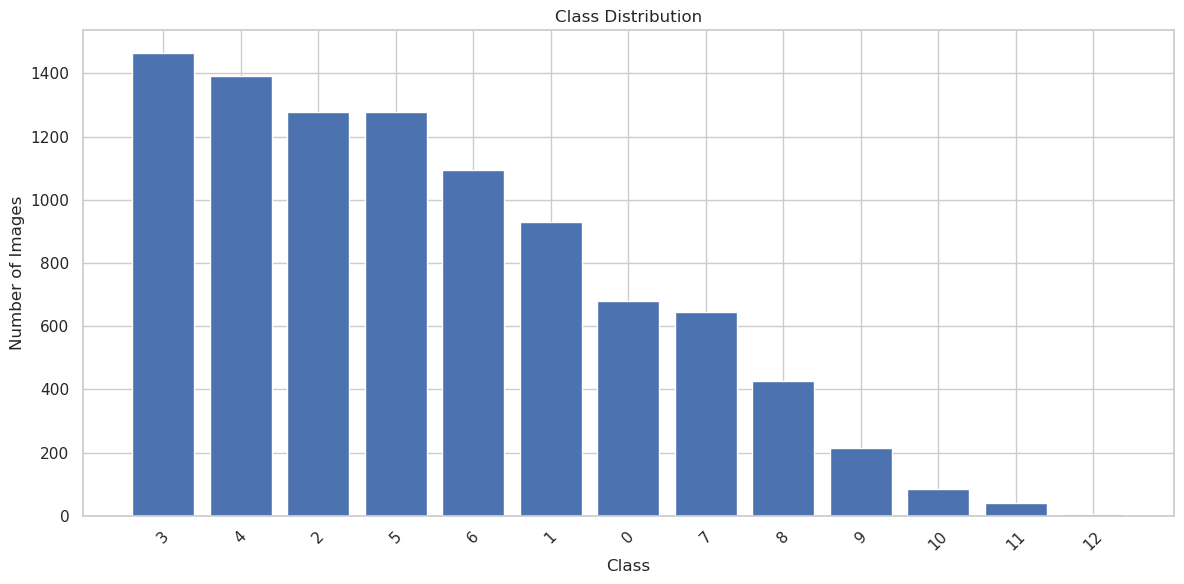

In [14]:
dataset_manager.plot_class_distribution()

### First Execution: Top 5 classes with highest probabilities


In [15]:
initial_classes = dataset_manager.get_class_subset(num_classes=7)
data_split = dataset_manager.prepare_data_split(initial_classes)

INFO:__main__:Collected 1463 images for class 3
INFO:__main__:Collected 1391 images for class 4
INFO:__main__:Collected 1279 images for class 2
INFO:__main__:Collected 1278 images for class 5
INFO:__main__:Collected 1094 images for class 6
INFO:__main__:Collected 929 images for class 1
INFO:__main__:Collected 680 images for class 0
INFO:__main__:Split sizes - Train: 5679, Val: 1217, Test: 1218


In [16]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
3    1243
4    1182
2    1087
5    1086
6     930
1     790
0     578
Name: count, dtype: int64
I0000 00:00:1731025780.206135  282190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731025780.233400  282190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731025780.233452  282190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731025780.236314  282190 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731025780.236352  282190 cuda_executor.cc:1001

#### Calculating Class Weights


In [17]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in initial_classes)

class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(initial_classes) * dataset_manager.class_counts[cls])
    for cls in initial_classes
}

In [18]:
steps_per_epoch, validation_steps = data_generator.get_steps()
logger.info(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

INFO:__main__:Steps per epoch: 215, Validation steps: 38


#### Initial Model


In [19]:
model = model_manager.build_model(data_generator.get_num_classes())
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 960)       │          0 │ MobileNetV3Large… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1920)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    983,040 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │      1,799 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,114,567 (15.70 MB)

 Trainable params: 1,117,191 (4.26 MB)

 Non-trainable params: 2,997,376 (11.43 MB)

In [20]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=1,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100


I0000 00:00:1731025795.558896  282258 service.cc:146] XLA service 0x7fd738014280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731025795.558950  282258 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-07 18:29:55.719907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 18:29:56.404840: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
2024-11-07 18:30:03.229036: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng32{k2=2,k6=0,k13=2,k14=0,k22=2} for conv (f16[32,1,1,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,1,1,120]{3,2,1,0}, f16[32,1,1,120]{3,2,1,0}, f16[32]{0}), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"ope

  7/216 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.0952 - loss: 2.9057   

I0000 00:00:1731025808.504839  282258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


207/216 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2331 - loss: 2.1285

E0000 00:00:1731025816.788455  282256 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731025817.046938  282256 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731025817.293975  282256 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-07 18:30:17.469336: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[16,7,7,960]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,7,7,960]{3,2,1,0}, f16[960,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2352 - loss: 2.1184

2024-11-07 18:30:23.927473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1779', 12 bytes spill stores, 12 bytes spill loads

E0000 00:00:1731025831.286498  282257 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731025831.519105  282257 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.47329, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 50s 116ms/step - accuracy: 0.2360 - loss: 2.1141 - val_accuracy: 0.4733 - val_loss: 1.2053 - learning_rate: 1.0000e-04
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4213 - loss: 1.3675
Epoch 2: val_accuracy improved from 0.47329 to 0.56204, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4213 - loss: 1.3674 - val_accuracy: 0.5620 - val_loss: 1.0617 - learning_rate: 1.0000e-04
Epoch 3/100
212/216 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4634 - loss: 1.2059
Epoch 3: val_accuracy improved from 0.56204 to 0.60559, saving model to saved_models/best_model_iter_1.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4634 - loss: 1.2059 - val_accuracy: 0.6056 - val_loss: 0.9851 - learning_rate: 1.0000e-04
Epoch 4/100
215/216 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - a

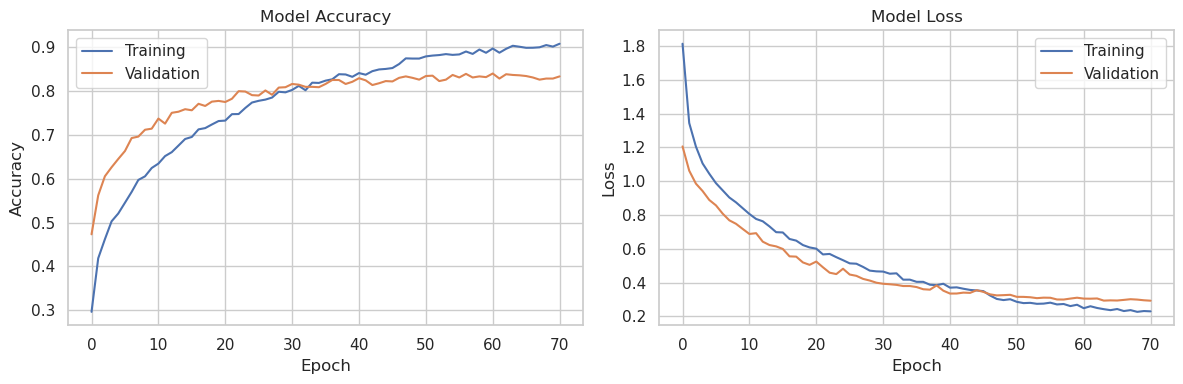

In [21]:
plot_history_subplot(history)

In [22]:
history_finetune = model_manager.fine_tune(
    train_gen,
    val_gen,
    iteration=1,
    num_layers_to_unfreeze=50,
    epochs=30,
    class_weights=class_weights,
)

INFO:__main__:Loaded best model from iteration 1


Epoch 1/30
213/216 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9006 - loss: 0.2427
Epoch 1: val_accuracy improved from -inf to 0.83566, saving model to saved_models/best_model_iter_1_ft.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.9006 - loss: 0.2427 - val_accuracy: 0.8357 - val_loss: 0.3017 - learning_rate: 1.0000e-05
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9003 - loss: 0.2446
Epoch 2: val_accuracy did not improve from 0.83566
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9003 - loss: 0.2446 - val_accuracy: 0.8324 - val_loss: 0.3042 - learning_rate: 1.0000e-05
Epoch 3/30
214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8934 - loss: 0.2480
Epoch 3: val_accuracy did not improve from 0.83566
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8935 - loss: 0.2479 - val_accuracy: 0.8348 - val_loss: 0.3020 - learning_rate: 1.0000e-05
Epoch 4/30
213/216 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9012 - loss: 0.2349


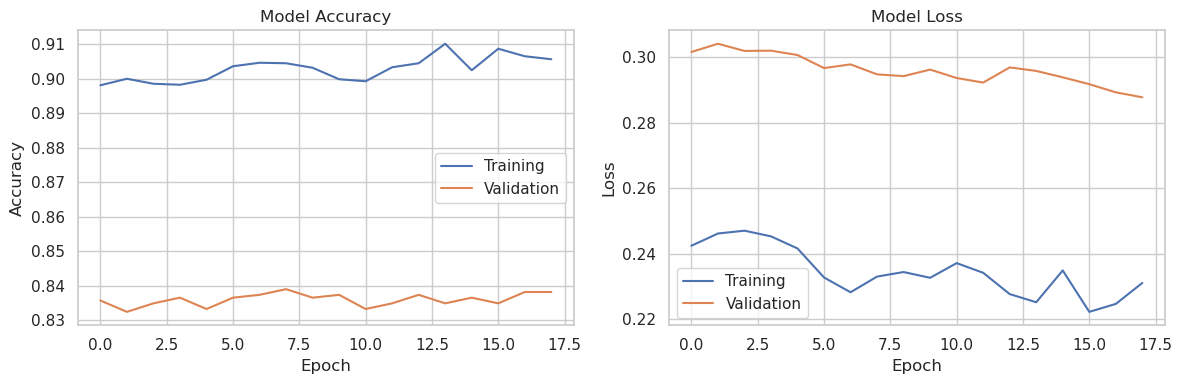

In [23]:
plot_history_subplot(history_finetune)

2024-11-07 18:47:22.665762: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-11-07 18:47:30.375061: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1749', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1731026854.455355  282259 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731026854.684091  282259 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-07 18:47:39.121952: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


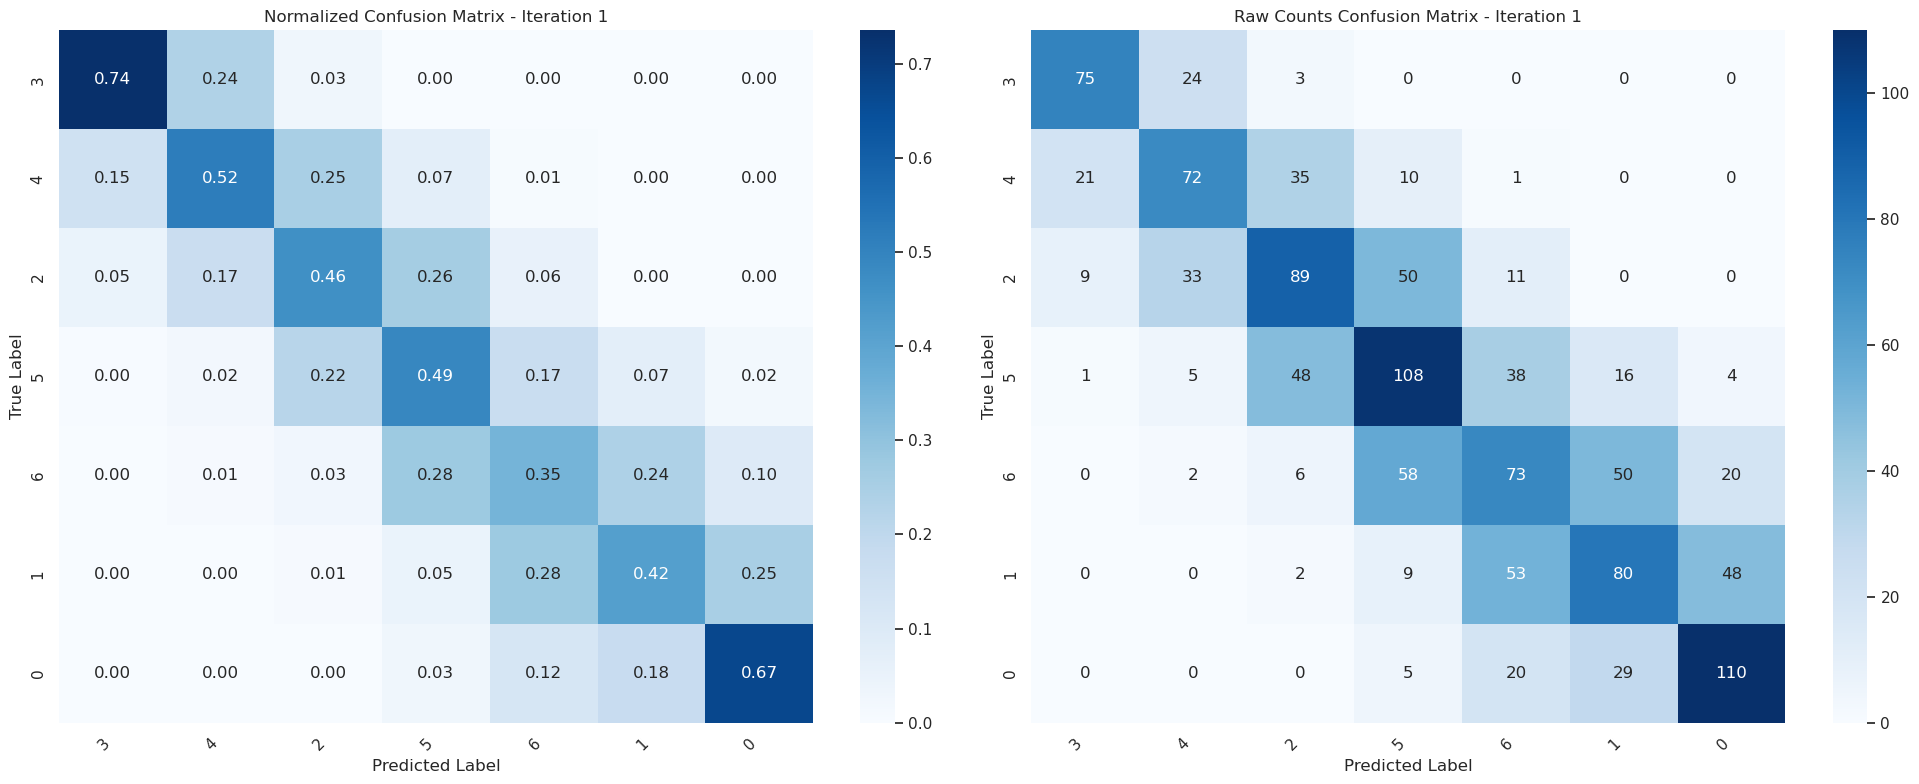

In [24]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=1, test_ds=test_gen, class_names=initial_classes
)

In [25]:
evaluator.print_classification_report(iteration=1)


Classification Report - Iteration 1
------------------------------------------------------------
3:::::::::::::: Precision: 0.708  Recall: 0.735  F1-score: 0.721
4:::::::::::::: Precision: 0.529  Recall: 0.518  F1-score: 0.524
2:::::::::::::: Precision: 0.486  Recall: 0.464  F1-score: 0.475
5:::::::::::::: Precision: 0.450  Recall: 0.491  F1-score: 0.470
6:::::::::::::: Precision: 0.372  Recall: 0.349  F1-score: 0.360
1:::::::::::::: Precision: 0.457  Recall: 0.417  F1-score: 0.436
0:::::::::::::: Precision: 0.604  Recall: 0.671  F1-score: 0.636
------------------------------------------------------------
Accuracy: 0.498


#### Second Iteration: The next classes with highest probabilities


In [40]:
all_classes = dataset_manager.get_class_subset(num_classes=9)
new_classes = all_classes[7:]

print(f"Original classes: {all_classes[:7]}")
print(f"New classes: {new_classes}")
print(f"All classes: {all_classes}")

Original classes: ['3', '4', '2', '5', '6', '1', '0']
New classes: ['7', '8']
All classes: ['3', '4', '2', '5', '6', '1', '0', '7', '8']


In [27]:
data_split = dataset_manager.prepare_data_split(all_classes)

INFO:__main__:Collected 1463 images for class 3
INFO:__main__:Collected 1391 images for class 4
INFO:__main__:Collected 1279 images for class 2
INFO:__main__:Collected 1278 images for class 5
INFO:__main__:Collected 1094 images for class 6
INFO:__main__:Collected 929 images for class 1
INFO:__main__:Collected 680 images for class 0
INFO:__main__:Collected 645 images for class 7
INFO:__main__:Collected 426 images for class 8
INFO:__main__:Split sizes - Train: 6429, Val: 1378, Test: 1378


In [28]:
train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

INFO:__main__:Training set class distribution:
class
3    1244
4    1182
2    1087
5    1086
6     930
1     790
0     578
7     548
8     362
Name: count, dtype: int64


In [29]:
total_samples = sum(dataset_manager.class_counts[cls] for cls in all_classes)
class_weights = {
    data_split.class_mapping[cls]: total_samples
    / (len(all_classes) * dataset_manager.class_counts[cls])
    for cls in all_classes
}

In [30]:
evaluator = ModelEvaluator(model_manager)

In [31]:
model_manager.prepare_next_iteration(
    previous_iteration=1,
    new_num_classes=len(all_classes),
)

INFO:__main__:Loaded best model from iteration 1_ft


In [32]:
history = model_manager.train(
    train_gen,
    val_gen,
    iteration=2,
    epochs=100,
    class_weights=class_weights,
)

Epoch 1/100
217/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6928 - loss: 0.4246

E0000 00:00:1731026888.204615  282261 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731026888.452821  282261 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6922 - loss: 0.4243
Epoch 1: val_accuracy improved from -inf to 0.73657, saving model to saved_models/best_model_iter_2.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.6922 - loss: 0.4243 - val_accuracy: 0.7366 - val_loss: 0.2675 - learning_rate: 1.0000e-05
Epoch 2/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6972 - loss: 0.3938
Epoch 2: val_accuracy did not improve from 0.73657
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6972 - loss: 0.3940 - val_accuracy: 0.7344 - val_loss: 0.2684 - learning_rate: 1.0000e-05
Epoch 3/100
242/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7070 - loss: 0.3620
Epoch 3: val_accuracy did not improve from 0.73657
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7069 - loss: 0.3623 - val_accuracy: 0.7366 - val_loss: 0.2647 - learning_rate: 1.0000e-05
Epoch 4/100
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7003 - loss: 0.3915
Epoch 4: va

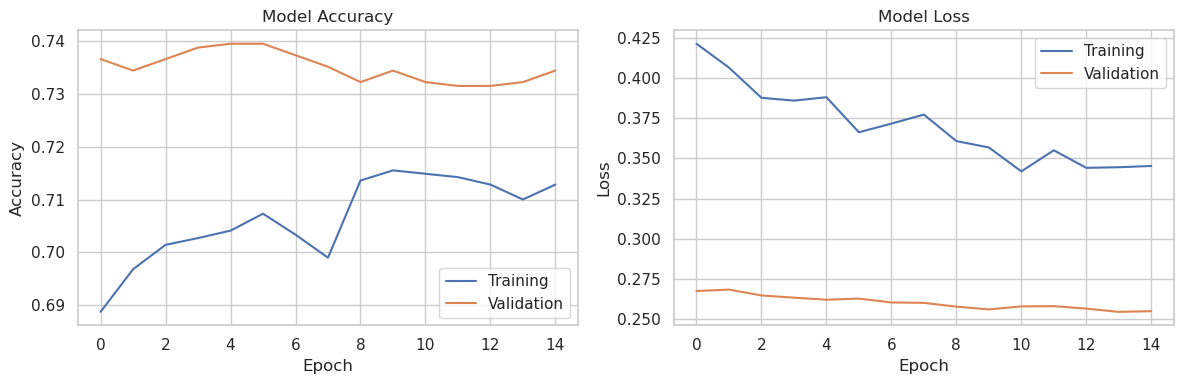

In [33]:
plot_history_subplot(history)

In [34]:
history_finetune = model_manager.fine_tune(
    train_gen,
    val_gen,
    iteration=2,
    num_layers_to_unfreeze=50,
    epochs=30,
    class_weights=class_weights,
)

INFO:__main__:Loaded best model from iteration 2


Epoch 1/30
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7063 - loss: 0.3674
Epoch 1: val_accuracy improved from -inf to 0.73730, saving model to saved_models/best_model_iter_2_ft.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.7063 - loss: 0.3674 - val_accuracy: 0.7373 - val_loss: 0.2615 - learning_rate: 1.0000e-06
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7065 - loss: 0.3736
Epoch 2: val_accuracy improved from 0.73730 to 0.73875, saving model to saved_models/best_model_iter_2_ft.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.7064 - loss: 0.3736 - val_accuracy: 0.7388 - val_loss: 0.2614 - learning_rate: 1.0000e-06
Epoch 3/30
243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7056 - loss: 0.3759
Epoch 3: val_accuracy did not improve from 0.73875
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7055 - loss: 0.3760 - val_accuracy: 0.7373 - val_loss: 0.2622 - learning_rate: 1.0000e-06
Epoch 4/30


2024-11-07 18:52:24.474505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:533: Filling up shuffle buffer (this may take a while): 221 of 7807


  2/244 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7422 - loss: 0.2829 

2024-11-07 18:52:25.220908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


243/244 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7062 - loss: 0.3741
Epoch 4: val_accuracy did not improve from 0.73875
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7062 - loss: 0.3741 - val_accuracy: 0.7380 - val_loss: 0.2611 - learning_rate: 1.0000e-06
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7096 - loss: 0.3748
Epoch 5: val_accuracy improved from 0.73875 to 0.73948, saving model to saved_models/best_model_iter_2_ft.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7096 - loss: 0.3748 - val_accuracy: 0.7395 - val_loss: 0.2627 - learning_rate: 1.0000e-06
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7048 - loss: 0.3695
Epoch 6: val_accuracy did not improve from 0.73948
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7048 - loss: 0.3695 - val_accuracy: 0.7388 - val_loss: 0.2615 - learning_rate: 1.0000e-06
Epoch 7/30
240/244 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7050 - loss: 0.3586
Epoch 7:

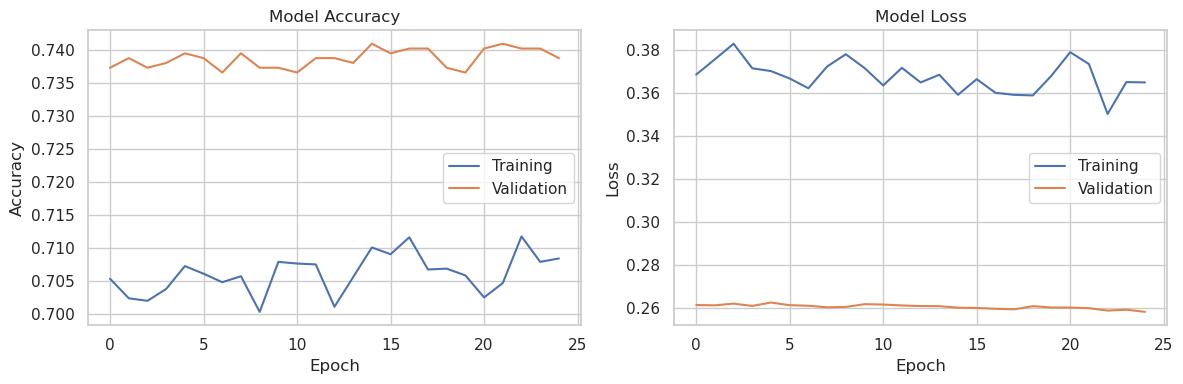

In [35]:
plot_history_subplot(history_finetune)

2024-11-07 18:57:02.474892: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


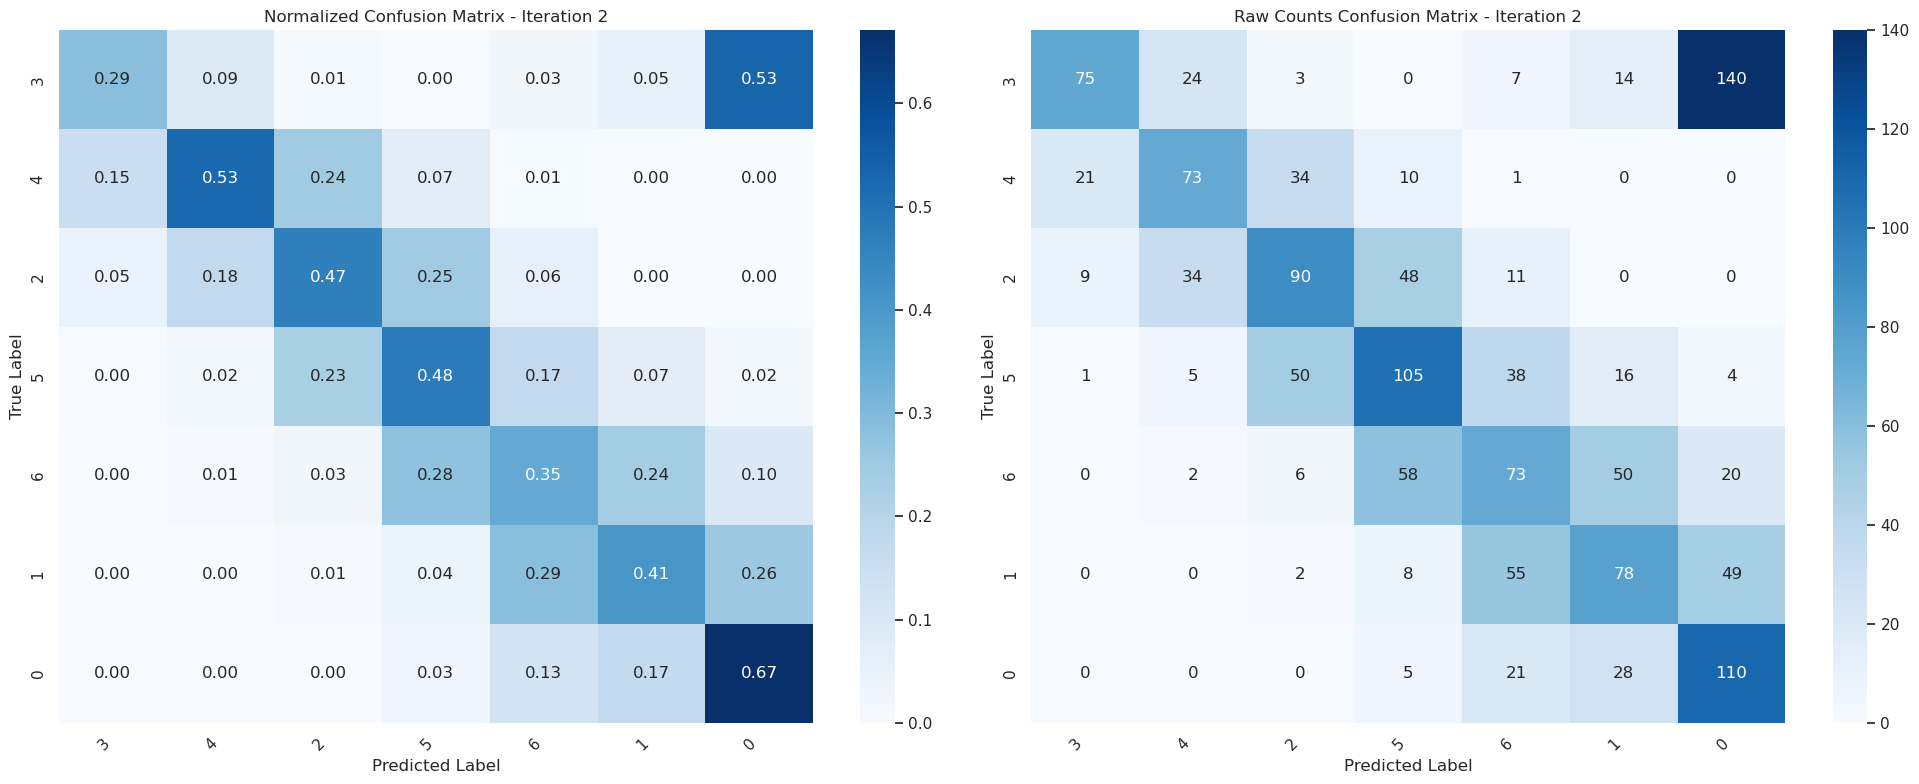

In [36]:
evaluation_results = evaluator.evaluate_iteration(
    iteration=2, test_ds=test_gen, class_names=all_classes
)

In [37]:
evaluator.print_classification_report(iteration=2)


Classification Report - Iteration 2
------------------------------------------------------------
3:::::::::::::: Precision: 0.708  Recall: 0.285  F1-score: 0.407
4:::::::::::::: Precision: 0.529  Recall: 0.525  F1-score: 0.527
2:::::::::::::: Precision: 0.486  Recall: 0.469  F1-score: 0.477
5:::::::::::::: Precision: 0.449  Recall: 0.479  F1-score: 0.464
6:::::::::::::: Precision: 0.354  Recall: 0.349  F1-score: 0.352
1:::::::::::::: Precision: 0.419  Recall: 0.406  F1-score: 0.413
0:::::::::::::: Precision: 0.341  Recall: 0.671  F1-score: 0.452
------------------------------------------------------------
Accuracy: 0.438
